In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import time
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from matplotlib.collections import PatchCollection
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, box, LineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, cKDTree, ConvexHull
from concurrent.futures import ProcessPoolExecutor, as_completed
import utils as NFLUtils

# Editing methods

In [16]:
# -----------------------------------------------------------------------------------------------------------------------------------------------------------
# Organizational methods

def load_game_data(tracking_file_path: str, plays_file_path: str, game_id: int, chunk_size:int = 10000)->pd.DataFrame:
    """
    Load rows from a CSV file that match a specific gameID

    Args:
    file_path (str): Path to the CSV file
    plays_file_path (str): path to the plays CSV file
    game_id (int): the gameID to filter by
    chunk_size (int, optional): the number of rows per chunk, default 10000

    Returns:
    pd.DataFrame: a DataFrame containing rows with the specified gameID
    """
    data = pd.DataFrame()
    # stream data in chunks
    for chunk in pd.read_csv(tracking_file_path, chunksize=chunk_size):
        filtered_chunk = chunk[chunk['gameId'] == game_id]
        # when no more matches, don't parse the rest of the file
        if filtered_chunk.shape[0] == 0:
            continue
        data = pd.concat([data, filtered_chunk], ignore_index=True)
    plays_df = pd.read_csv(plays_file_path)
    data = pd.merge(data, plays_df.loc[:,['gameId', 'playId', 'possessionTeam', 'ballCarrierId']], on=['gameId', 'playId'])
    data = data.loc[data['club'] != 'football']
    data['is_offense'] = (data['possessionTeam'] == data['club'])
    return data

def organize_game_data(df: pd.DataFrame)->dict:
    """
    Organize game data into a nested dictionary structure.

    Args:
    df (pd.DataFrame): The DataFrame containing game data.

    Returns:
    dict: A nested dictionary with plays as keys and dictionaries of data where the key is the frame and the values are data from that frame
    """

    # Initialize the main dictionary
    game_dict = {}

    # Iterate over each unique play in the DataFrame
    for play_id in df['playId'].unique():

        play_df = df[df['playId'] == play_id]
        play_events = play_df['event'].unique()


        #for now, ignoring fumbles, but maybe later on we can count that as a tackle?
        if 'fumble' in play_events:
          continue
        
        play_df = play_df.copy()
        if play_df['playDirection'].iloc[0] == 'left':
          play_df['x'] = 120 - play_df['x']
          play_df['y'] = 53.3 - play_df['y']


        # Initialize the play's dictionary
        play_dict = {}

        start_frame = 1
        #another potentiall type of event to include is 'run', but for now i'm excluding that
        #because I'm not exactly sure what it means
        if 'pass_outcome_caught' in play_events:
          start_frame = play_df.loc[play_df['event'] == 'pass_outcome_caught']['frameId'].min()
        elif 'handoff' in play_events:
          start_frame = play_df.loc[play_df['event'] == 'handoff']['frameId'].min()
        else:
          continue

        #this limits us to plays where a tackle is made
        #not sure if we need special consideration for when a runner scores, so those plays are ignored for now
        #potentially could include 'out_of_bounds' and factor that into defensive play as well
        end_frame = 1
        if 'tackle' in play_events:
          end_frame = play_df.loc[play_df['event'] == 'tackle']['frameId'].min()
        else:
          continue

        # Iterate over each player in the play
        for frame_id in play_df['frameId'].unique():
            if (frame_id < start_frame) or (frame_id > end_frame):
              continue
            frame_df = play_df[play_df['frameId'] == frame_id]

            # Select and sort relevant columns
            columns = ['nflId', 'time', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'is_offense', 'ballCarrierId']
            frame_df = frame_df[columns]
            frame_df = frame_df.astype({'nflId': int, 'ballCarrierId': int})
            
            # Add the player's DataFrame to the play's dictionary
            play_dict[frame_id] = frame_df

        # Add the play's dictionary to the main dictionary
        game_dict[play_id] = play_dict

    return game_dict





In [ ]:
# -----------------------------------------------------------------------------------------------------------------------------------------------------------
# Voronoi methods

def in_box(players, bounding_box):
    """ 
    Check if a point is in a box (works in conjunction with calculate_voronoi_areas)
    Params: 
    - players (np.array()): a 2D array of the coordinates of all the players
    - bounding_box (tuple): the coordinates of the bounds in the form (x_min, x_max, y_min, y_max)
    """
    return np.logical_and(np.logical_and(bounding_box[0] <= players[:, 0],
                                         players[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= players[:, 1],
                                         players[:, 1] <= bounding_box[3]))

def calculate_voronoi_areas(df, x_min:float=10, x_max=110, y_min=0, y_max=53.3, plot_graph:bool=False, tpc_dict:dict=None, ax=None): 
    """
    Custom Voronoi utils. TLDR: mirror the points over x_min, x_max, y_min, y_max to create a boundaries. Use shoelace method to calculate area of each region. Some become negative because of quirks w the floating point numbers
    
    df (pd.DataFrame): the data frame of frame_data from the organize_game_data method. Has columsn: [nflId	time, playDirection, x, y, s, a, dis, o, dir, event, is_offense, ballCarrierId]
    x_min (float): the minimum x value at which we end analysis
    x_max (float): max x value in the analysis, default 110 because that's the endzone
    y_min (float), y_max(float): bounds for y
    plot_graph (bool): whether you want to generate a plot or not
    tpc_dict (dict): a dictionary indexed by nflId with the TPC for that frame of every player. Used in the plot_graph if specified. 
    ax: if calling from another method, pass the axis
    """
    
    # create a boundary 10 yards behind the ball carrier or 10 yds (start of endzone), whichever is greater
    if not x_min: 
        x_min = max(df[df.nflId==df.ballCarrierId.iloc[0]].x.iloc[0] - 10, 10)

    # filter points to the ones in the relevant region
    df_filtered = df[df['x'].between(x_min, x_max) & df['y'].between(y_min, y_max)].copy() # this seems redundant, but we need the df to be filtered to match each point to an nflId in the future. 
    players = df_filtered[['x', 'y']].to_numpy()
    bounding_box = (x_min, x_max, y_min, y_max)

    # Select towers inside the bounding box
    i = in_box(players, bounding_box)
    # Mirror points
    points_center = players[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)

    # only pay attention to the points related to players in the relevant region
    vor.filtered_points = points_center
    vor.filtered_regions = [vor.regions[vor.point_region[i]] for i in range(len(points_center))]
    vertices = [vor.vertices[vor.filtered_regions[idx], :] for idx in range(len(vor.filtered_regions))]
    areas = [ConvexHull(vor.vertices[vor.filtered_regions[idx], :]).volume for idx in range(len(vor.filtered_regions))]  # pull the areas and zip them indexed to the vertices passed in
    df_filtered['voronoi_area'] = areas
    df_filtered['vertices'] = vertices

    # optionally, plot the graph
    if plot_graph:

        # Plot Voronoi diagram
        if not ax: # if there is no tpc_dict, this method is being called by itself and not with the helper animation() within tackle_percentage_contribution_per_play(), so we create a figure and plot
            fig, ax = plt.subplots(figsize=(24,16))

        # clear whatever was on the axis before
        ax.clear()
        
        # Plot boundaries
        # ax.add_patch(patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='black'))

        for i, region in enumerate(vor.filtered_regions):
            polygon = [vor.vertices[i] for i in region]
            ax.fill(*zip(*polygon), fill=False, color='white', edgecolor='black')

            # Label points with nflId (smaller font size)
            nfl_id = df_filtered.iloc[i]['nflId']
            if tpc_dict: 
                player_tpc = tpc_dict.get(nfl_id, "") # try getting the TPC, and if not found, return a null value
            else:  # if no dict specified, no player has TPC
                player_tpc=""
            ax.text(vor.filtered_points[i][0], vor.filtered_points[i][1]-.75, f'{str(nfl_id)}: {player_tpc}', fontsize=10, ha='center', va='center') # the -.75 is to offset the points

            # Color points based on conditions
            if nfl_id == df_filtered.iloc[i]['ballCarrierId']:
                ax.plot(vor.filtered_points[i][0], vor.filtered_points[i][1], 'ro', markersize=10, label='Ball Carrier')
            elif nfl_id in df_filtered[df_filtered['is_offense']]['nflId'].tolist():
                ax.plot(vor.filtered_points[i][0], vor.filtered_points[i][1], 'mo', markersize=10, label='Offense')
            else:
                ax.plot(vor.filtered_points[i][0], vor.filtered_points[i][1], 'go', markersize=10, label='Defense')

        ballCarrierId = df_filtered[df_filtered['nflId'] == df_filtered.iloc[0]['ballCarrierId']]['ballCarrierId'].values[0]
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # ax.gca().set_aspect('equal', adjustable='box')
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.set_title(f'Voronoi Diagram (BallCarrierId: {ballCarrierId})')
        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Ball Carrier', markerfacecolor='r', markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Offense', markerfacecolor='m', markersize=10),
                        Line2D([0], [0], marker='o', color='w', label='Defense', markerfacecolor='g', markersize=10)]
        ax.legend(handles=legend_elements)
    
    return df_filtered

def angle_from_vector(x_0, y_0, velocity_x, velocity_y, x, y):
    vector_to_point = np.array([x - x_0, y - y_0])
    velocity_vector = np.array([velocity_x, velocity_y])
    magnitude_vector_to_point = np.linalg.norm(vector_to_point)
    magnitude_velocity_vector = np.linalg.norm(velocity_vector)
    dot_product = np.dot(velocity_vector, vector_to_point)
    cosine_theta = dot_product / (magnitude_velocity_vector * magnitude_vector_to_point)
    theta_radians = np.arccos(cosine_theta)
    theta_degrees = np.degrees(theta_radians)
    abs_theta_degrees = np.abs(theta_degrees)
    return theta_degrees

def weight_space(x_0, y_0, velocity_x, velocity_y, x, y, speed):
    distance = np.sqrt((x - x_0)**2 + (y - y_0)**2)
    angle_from_velocity = angle_from_vector(x_0, y_0, velocity_x, velocity_y, x, y)
    angle_from_endzone = angle_from_vector(x_0, y_0, 1, 0, x, y)
    return 1 / ((distance**(1/4)) * ((speed / 2) * angle_from_velocity + angle_from_endzone)**(1/2))

def calculate_weighted_area(vertices, x_0, y_0, dir, speed):
  '''
  vertices: list of tuples representing the coordinates that define the voronoi space
  x_0, y_0: position of the ball carrier
  dir: direction of the ball carrier
  speed: speed of the ball carrier
  '''
  velocity_x = speed * np.sin(np.radians(dir)) * 10
  velocity_y = speed * np.cos(np.radians(dir)) * 10

  area = 0.0
  for i in range(len(vertices)):
      x1, y1 = vertices[i]
      w1 = weight_space(x_0, y_0, velocity_x, velocity_y, x1, y1, speed)
      x2, y2 = vertices[(i + 1) % len(vertices)]
      w2 = weight_space(x_0, y_0, velocity_x, velocity_y, x2, y2, speed)
      area += (x1 * y2 * w2 - x2 * y1 * w1)

  area = 0.5 * abs(area)
  return area

def check_matching_vertices(vertices, ball_carrier_vertices):
    matching_vertices = [v for v in vertices if v in ball_carrier_vertices] 

def recognize_adjacent_players(df:pd.DataFrame, x_min:float=None, x_max=110, y_min=0, y_max=53.3)->pd.DataFrame:
    """ 
    Return a adjusted voronoi analysis that adds the voronoi areas of blockers immediately adjacent to the ball carrier.

    Params: 
    - df (pd.DataFrame): output of the calculate_voronoi_areas method
    - x_min:float=None, x_max=110, y_min=0, y_max=53.3 the boundaries of the method

    Returns: 
    - df (pd.DataFrame): the only number different is the voronoi_area of the ballCarrierId
    """

    # create a boundary 10 yards behind the ball carrier or 10 yds (start of endzone), whichever is greater
    if not x_min: 
        x_min = max(df[df.nflId==df.ballCarrierId.iloc[0]].x.iloc[0] - 10, 10)
    
    # Find the row where nflId equals ballCarrierId
    ball_carrier_row = df[df['nflId'] == df['ballCarrierId']].iloc[0]
    ball_carrier_vertices = ball_carrier_row['vertices']

    # Filter out non-offense players and the ball carrier
    offense_players = df[(df['is_offense']) & (df['nflId'] != df['ballCarrierId'])].copy()

    # Apply the function to check for matching vertices
    offense_players['matching_vertices'] = offense_players.vertices.apply(check_matching_vertices, args=(ball_carrier_vertices))

    # Calculate the additional area
    additional_area = offense_players[offense_players['matching_vertices']]['weighted_voronoi_area'].sum()
    blockers = [penis.tolist() for index, penis in offense_players[offense_players['matching_vertices']][['nflId', 'weighted_voronoi_area', 'vertices']].iterrows()]

    # Update the ball carrier's voronoi area
    df.loc[df['nflId'] == df['ballCarrierId'], 'weighted_voronoi_area'] += additional_area
    
    return df, blockers


In [104]:
def ccw(a, b, c)->bool:
    return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

def line_intersects_segment(p1: list[float, float], p2: list[float, float], 
                            q1: list[float, float], q2: list[float, float]) -> bool:
    """
    Check if the line segment p1-p2 intersects with the line segment q1-q2.
    """
    return (ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2))

def find_clear_path(df:pd.DataFrame)->list:
    """
    Find a player's position that has a clear path from the ball carrier.
    If a clear path exists, return the index of that player's position. 
    If not, return -1.
    """
    # empty list to hold blockers
    blockers = []

    # record the ball carrier's vertices
    ball_carrier_row = df[df['nflId'] == df['ballCarrierId']].iloc[0]
    x_0, y_0 = ball_carrier_row[['x', 'y']]
    # record the offensive player positions
    player_positions = df[df.is_offense][['nflId', 'x','y']]
    # record the voronoi regions of the defensive players
    voronoi_regions = df[~df.is_offense]['vertices']
    
    # iterate over the positions of the offensive players that are potentially blockers
    for _, id, x, y in player_positions.itertuples():
        # break for the ball carrier 
        if id == ball_carrier_row.nflId:
            continue
        path_clear = True
        for polygon in voronoi_regions:
            for j in range(len(polygon)):
                # Check if the line intersects with any of the polygon's edges
                if line_intersects_segment((x_0, y_0), (x,y), polygon[j], polygon[(j + 1) % len(polygon)]):
                    path_clear = False
                    break
            if not path_clear:
                break
        
        if path_clear:
            blockers.append(id)  # Clear path found to this player

    return blockers

def recognize_blockers(df:pd.DataFrame):
    blockers = find_clear_path(df)
    additional_area = df[df['nflId'].isin(blockers)]['weighted_voronoi_area'].sum()
    # Update the ball carrier's voronoi area
    df.loc[df['nflId'] == df['ballCarrierId'], 'weighted_voronoi_area'] += additional_area
    return df


In [101]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------
# TPC Methods

def tackle_percentage_contribution_per_frame(frame_data:pd.DataFrame)->dict:
    """ 
    For every unique player attributed to a square on the defending team, take them out and see how much Voronoi area would be gained by the player in possession. 

    Params: 
    - frame_data (pd.DataFrame): a dataframe from the organize_game_data method with columns ['nflId', 'ballCarrierId', 'is_offense', 'x', 'y']

    Returns: 
    - dictionary with keys of nflId and value of the tackle percentage contribution for that frame
    """
    area_protected = {}
    # get the ball carrier and offensive players
    ballCarrier = frame_data.ballCarrierId.iloc[0]
    x, y, dir, s = frame_data[frame_data.nflId==ballCarrier].iloc[0].loc[['x', 'y', 'dir', 's']]  # get the x, y, direction, and speed of the ball carrier for weighting method
    offensive_players = dict(zip(frame_data.nflId, frame_data.is_offense)) # dict to store whether the player is offense or not

    # get the minimum x, after which we will cut off voronoi analysis
    frame_data = calculate_voronoi_areas(frame_data)
    # frame_data['weighted_voronoi_area'] = frame_data.vertices.apply(calculate_weighted_area, args=(x, y, dir, s)) # (weighted)
    frame_data['weighted_voronoi_area'] = frame_data.voronoi_area # (unweighted)
    frame_data = recognize_blockers(frame_data) # (toggle to recognize adjacent blockers or not)
    baseline_area = frame_data.loc[frame_data.nflId==ballCarrier, 'weighted_voronoi_area'].iloc[0] # baseline area of the ball carrier
    print(f'baseline area of ball carrier: {baseline_area}')
    # print(f'initial blockers: {blockers}')
    
    # iterate through the IDs of the players
    for player_id in frame_data.nflId.unique(): 
        # break for the ball_carrier     
        if offensive_players[player_id]: 
            continue
        # take the frame data if that player didn't exist
        filtered_frame_data = frame_data[frame_data.nflId != player_id]
        filtered_frame_data = calculate_voronoi_areas(filtered_frame_data)
        # filtered_frame_data['weighted_voronoi_area'] = filtered_frame_data.vertices.apply(calculate_weighted_area, args=(x, y, dir, s))
        filtered_frame_data['weighted_voronoi_area'] = filtered_frame_data.voronoi_area # toggle to weight area or not
        filtered_frame_data = recognize_blockers(filtered_frame_data) # toggle to recognize adjacent players or not
        protected_area = filtered_frame_data.loc[filtered_frame_data.nflId==ballCarrier, 'weighted_voronoi_area'].iloc[0] # baseline area of the ball carrier
        # DEBUG
        # print(f'{player_id} removed, blockers: {blockers}, protected area: {protected_area}')
        # calculate how much additional space the offense gets
        area_protected[player_id] = round(protected_area - baseline_area, 4)  # how much more area do they get?

    return area_protected

def tackle_percentage_contribution_per_play(frame_dict:dict, filepath:str, animation:bool=False): 
    """
    This iterates through the frames in any given play and calculates the tackle percentage contribution of each player
    
    Params: 
    - frame_dict: dict from the organize_game_data method for each play
    - filepath (str): the filepath of the folder under which we are caching play data
    - animation (bool): whether or not we want to make an MP4 of the play

    Returns: 
    - dictionary with keys of nflId and value of the tackle percentage contribution for that play
    """
    # empty dict, one indexed by player, the other indexed by frame
    total_tpc = {}
    tpc_per_frame = {}

    # sort the frames
    frame_dict_sorted = sorted(frame_dict.items(), key=lambda x: x[0])
    # iterate through the frames of the play
    for key, frame in frame_dict_sorted: 
        print(f'################################## {key} ###############################')

        # get protected areas, append to both dictionaries
        frame_tpc = tackle_percentage_contribution_per_frame(frame)
        tpc_per_frame[key] = frame_tpc

        # append to the overall dict for the play
        for player, contribution in frame_tpc.items():
            if player in total_tpc.keys(): 
                total_tpc[player] += contribution
            else: 
                total_tpc[player] = contribution
    
    # normalize every player's contribution such that it sums to 1
    total_protected_area = sum(total_tpc.values())
    for key, value in total_tpc.items():
        total_tpc[key] = value / total_protected_area


    # Convert the dictionary with the frame data to a DataFrame to cache
    # The keys of the outer dict become the index, and the inner dicts' keys become the column names
    tpc_per_frame_df = pd.DataFrame.from_dict(tpc_per_frame, orient='index')

    # Save to CSV, with the index to make future multiplication easier
    # tpc_per_frame_df.to_csv(f'{filepath}/tpc_per_frame_weighted.csv', index=True)
    tpc_per_frame_df.to_csv(f'{filepath}/tpc_per_frame_unweighted.csv', index=True)

    # cast everything to strings from int64 (otherwise cannot store in JSON)
    total_tpc_converted = {int(key): value for key, value in total_tpc.items()}

    # cache this result as a JSON for each play
    # json.dump(total_tpc_converted, open(filepath+'/tpc_weighted.json', 'w'))
    json.dump(total_tpc_converted, open(filepath+'/tpc_unweighted.json', 'w'))
    
    # if the animation method is called
    if animation: 

        # open plots were taking too much memory
        plt.close('all')
        
        def animate(frame_number:int, ax:plt.Axes):
            """
            frame_number (int): the number of the frame, pulling from the nonlocal frame_dict 
            ax (plt.ax): passing the axis for the whole gif into the method, doesn't work otherwise (not sure why)
            """
            # Get the dataframe for the current frame
            current_frame = frame_dict[frame_number]

            # Call the calculate_voronoi_areas function with plot_graph=True
            calculate_voronoi_areas(current_frame, plot_graph=True, tpc_dict=tpc_per_frame[frame_number], ax=ax)

        fig, ax = plt.subplots(figsize=(24, 16))
        ani = FuncAnimation(fig, lambda x: animate(x, ax), frames=sorted(frame_dict.keys()), repeat=False)
        
        # Save the animation
        ani.save(filepath + '/voronoi_visualizer_unweighted.mp4', writer='ffmpeg')

    return total_tpc

def analyze_play(key:int, play:dict, filepath:str, animation:bool):
    """
    Wrapper function to analyze a single play. This function will be executed in parallel.
    Params: 
    - key (int): the play number
    - play (dict): a dictionary of the frames (pd.DataFrame) of each play
    - filepath (str): the filepath of tha game within which we will save information/animations of the play
    """
    print(key)  # For debugging purposes

    # Define the play's file path
    play_filepath = f'{filepath}/{key}'
    if not os.path.exists(play_filepath):
        os.makedirs(play_filepath)

    try:
        # Calculate the tackle_percentage_contribution
        # Ensure that the tackle_percentage_contribution_per_play function is defined appropriately
        play_tpc = tackle_percentage_contribution_per_play(frame_dict=play, filepath=play_filepath, animation=animation)

        return {player: contribution for player, contribution in play_tpc.items()}
    except Exception as e:
        print(f'Error processing play {key}: {e}')
        return {}

def analyze_game(game_id, tracking_file, plays_file='./data/plays.csv', game_file='./data/games.csv', animation:bool=False):
    """ 
    A method to analyze a game. Calling this will analyze and cache all the plays + the results of the analysis
    Param: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - plays_file (str): the address of the plays file
    - game_file (str): the filepath of the file containing information about each game
    """
    
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Dictionary to store the overall tackle_percentage_contribution
    game_tpc = {}

    # Using ProcessPoolExecutor to parallelize the loop
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(analyze_play, key, play, filepath, animation) for key, play in sorted_game_data_organized]

        for future in as_completed(futures):
            play_tpc = future.result()
            for player, contribution in play_tpc.items():
                game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Convert game_tpc keys from int64 to string to store in JSON
    game_tpc_converted = {int(key): value for key, value in game_tpc.items()}

    # Cache this result as a JSON for each game
    # json.dump(game_tpc_converted, open(filepath + '/game_tpc.json', 'w'))
    json.dump(game_tpc_converted, open(filepath + '/game_tpc_unweighted.json', 'w'))

    return game_tpc

def analyze_game_unparallelized(game_id, tracking_file, plays_file='./data/plays.csv', players_file='./data/players.csv', game_file='./data/games.csv', animation:bool=False):
    """ 
    A method to analyze a game. Calling this will analyze and cache all the plays + the results of the analysis
    Param: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - x_step, y_step (float): the x and y steps of each of the voronoi bins
    - plays_file (str): the address of the plays file
    - players_file (str): the filepath of the file containing players [TODO: CURRENTLY UNUSED.]
    - game_file (str): the filepath of the file containing information about each game
    """
    
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Dictionary to store the overall tackle_percentage_contribution
    game_tpc = {}

    for key, play in sorted_game_data_organized: 
        play_tpc = analyze_play(key, play, filepath, animation)
        for player, contribution in play_tpc.items():
            game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Convert game_tpc keys from int64 to string to store in JSON
    game_tpc_converted = {str(key): value for key, value in game_tpc.items()}

    # Cache this result as a JSON for each game
    json.dump(game_tpc_converted, open(filepath + '/game_tpc_voronoi_unweighted.json', 'w'))

    return game_tpc

def analyze_play_unparallelized(play_number, game_id, tracking_file, plays_file='./data/plays.csv', players_file='./data/players.csv', game_file='./data/games.csv', animation:bool=False):
    """ 
    A method to analyze a game. Calling this will analyze and cache all the plays + the results of the analysis
    Param: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - x_step, y_step (float): the x and y steps of each of the voronoi bins
    - plays_file (str): the address of the plays file
    - players_file (str): the filepath of the file containing players [TODO: CURRENTLY UNUSED.]
    - game_file (str): the filepath of the file containing information about each game
    """
    
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Dictionary to store the overall tackle_percentage_contribution
    game_tpc = {}

    for key, play in sorted_game_data_organized: 
        if key != play_number: 
            continue
        play_tpc = analyze_play(key, play, filepath, animation)
        for player, contribution in play_tpc.items():
            game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Convert game_tpc keys from int64 to string to store in JSON
    game_tpc_converted = {str(key): value for key, value in game_tpc.items()}

    # Cache this result as a JSON for each game
    json.dump(game_tpc_converted, open(filepath + '/game_tpc.json', 'w'))

    return game_tpc

# Analyze Players

### Check up on a game

In [2]:
week = 3 # CHANGE ME!
game_id = 2022092200 # CHANGE ME!
tracking_file = f'./data/tracking_week_{week}.csv'

In [3]:
# the animation and dataframe per play will show up in './games/{game_id}/{play}
result = NFLUtils.analyze_game_unparallelized(game_id, tracking_file, animation=False)

          gameId  playId  frameId  frameId_start  frameId_end  startFootballX  \
0     2022092200      56       20           20.0         47.0           29.50   
1     2022092200      56       21           20.0         47.0           29.50   
2     2022092200      56       22           20.0         47.0           29.50   
3     2022092200      56       23           20.0         47.0           29.50   
4     2022092200      56       24           20.0         47.0           29.50   
...          ...     ...      ...            ...          ...             ...   
2924  2022092200    4085       57           20.0         61.0           68.82   
2925  2022092200    4085       58           20.0         61.0           68.82   
2926  2022092200    4085       59           20.0         61.0           68.82   
2927  2022092200    4085       60           20.0         61.0           68.82   
2928  2022092200    4085       61           20.0         61.0           68.82   

      endFootballX  currFoo

In [5]:
week_1_tracking_file = './data/tracking_week_3.csv'
plays_file = './data/plays.csv'

valid_plays = pd.read_csv('./data/eval_frame_df.csv')
valid_plays = valid_plays[valid_plays.gameId==2022092200]

game_data = NFLUtils.load_game_data(week_1_tracking_file, plays_file, 2022092200)
# print(game_data.head())
game_data_organized = NFLUtils.organize_game_data(game_data, valid_plays)
print("Number of plays: ", len(game_data_organized.keys()))

Number of plays:  97


In [6]:
# format of the organized data: 
test_frame = game_data_organized[2156][30]
test_frame

,nflId,time,playDirection,x,y,s,a,dis,o,dir,event,is_offense,ballCarrierId
53412,44814,2022-09-22 21:56:13.700000,right,37.21,27.36,4.01,1.99,0.41,93.86,298.94,first_contact,True,53453
53467,44903,2022-09-22 21:56:13.700000,right,59.42,24.27,3.37,2.38,0.32,280.55,317.68,first_contact,False,53453
53522,44974,2022-09-22 21:56:13.700000,right,46.79,27.74,0.09,3.73,0.02,202.93,160.26,first_contact,False,53453
53577,45038,2022-09-22 21:56:13.700000,right,46.54,32.78,1.96,1.33,0.20,160.44,62.79,first_contact,False,53453
53632,46073,2022-09-22 21:56:13.700000,right,51.47,10.23,3.54,0.81,0.35,231.00,119.29,first_contact,False,53453
53687,46098,2022-09-22 21:56:13.700000,right,45.99,29.45,2.37,2.05,0.26,195.79,76.71,first_contact,False,53453
53742,46108,2022-09-22 21:56:13.700000,right,47.42,27.14,2.80,1.40,0.29,47.35,56.39,first_contact,True,53453
53797,46161,2022-09-22 21:56:13.700000,right,48.52,26.76,3.50,0.49,0.36,21.75,43.63,first_contact,True,53453
53852,46166,2022-09-22 21:56:13.700000,right,46.24,28.08,0.42,1.14,0.05,111.50,79.54,first_contact,True,53453
53907,47849,2022-09-22 21:56:13.700000,right,50.08,9.02,3.71,1.51,0.38,267.87,124.46,first_contact,True,53453


In [7]:
NFLUtils.tackle_percentage_contribution_per_frame(test_frame)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 360 but corresponding boolean dimension is 60

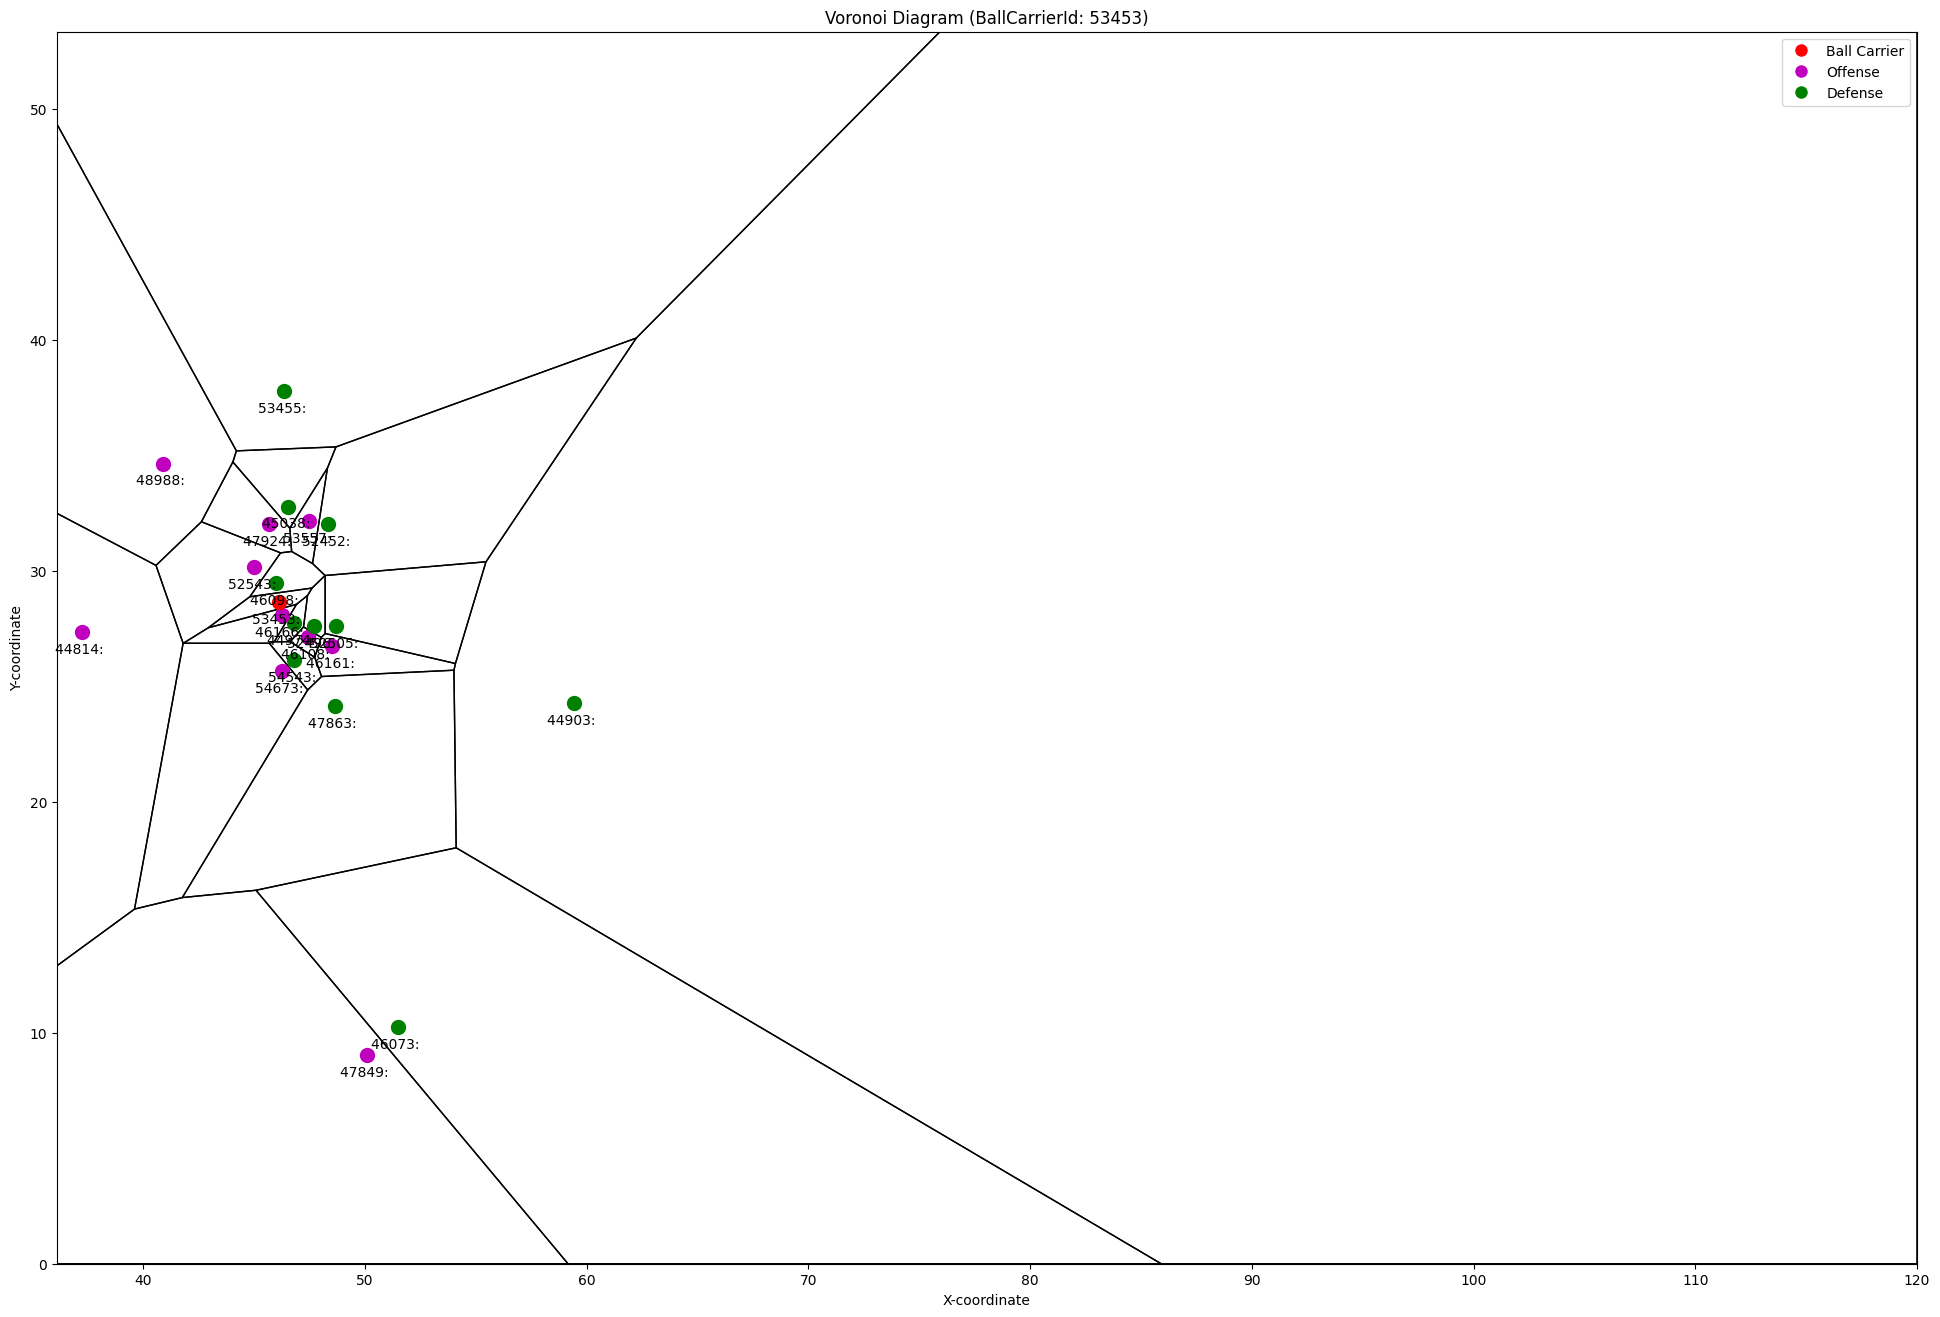

In [10]:
test_frame = NFLUtils.calculate_voronoi_areas(test_frame, plot_graph=True)


In [96]:
find_clear_path(test_frame)

      nflId      x      y
1216  35472  48.74  22.42
1363  42392  49.28  21.39
1461  42818  50.45  13.20
1657  44875  48.04  24.20
1706  46076  43.93  22.58
1804  47857  41.18  20.29
1902  47879  46.93  15.47
2098  48512  47.61  19.50
2147  52536  49.04  32.11
2196  53079  46.90  17.68
2245  53522  48.62  18.72
True
False
False
False
False
False
False
False
True
True
True
False
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
False
True
False
True
False
True
True
False
False
False
False
False
True
True
False
True
True
False
False
False
False
False
False
True
False
True
False
True
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
True
False
False
True
True
True
False
False
False
False
False
True
True
False
True
True
True
False
True
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
True
True
True
False
True
False
True
False
False
True
False
False
False

[46076, 47857, 47879, 48512, 53079, 53522]

In [105]:
recognize_blockers(test_frame)

True
False
False
False
False
False
False
False
True
True
True
False
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
False
True
False
True
False
True
True
False
False
False
False
False
True
True
False
True
True
False
False
False
False
False
False
True
False
True
False
True
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
True
False
False
True
True
True
False
False
False
False
False
True
True
False
True
True
True
False
True
False
True
True
False
False
False
False
False
True
True
False
True
False
False
False
False
False
False
False
True
True
True
False
True
False
True
False
False
True
False
False
False
True
True
False
False
True
False
False
False
False
True
True
True
False
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
False
True
False
True
True
True
True
True
False
False
False
False
False
False
False
True
False
True
True
False
False
False
False
False
False
True
False
True


KeyError: 'weighted_voronoi_area'

,nflId,time,playDirection,x,y,s,a,dis,o,dir,event,is_offense,ballCarrierId,voronoi_area,vertices
12190,34452,2022-09-08 20:37:58.599999,right,51.20,27.18,1.31,0.49,0.13,199.36,165.26,NaN,True,44881,5.374061,"[[51.76778462998102, 25.968078747628084], [48...."
12219,37075,2022-09-08 20:37:58.599999,right,46.54,29.23,0.76,1.25,0.07,84.97,78.58,NaN,False,44881,777.572669,"[[47.461522249923775, 25.636771205136945], [22..."
12248,40107,2022-09-08 20:37:58.599999,right,72.80,22.93,5.02,2.22,0.51,239.80,248.03,NaN,False,44881,991.123738,"[[67.2577405714017, 20.673168366807033], [69.9..."
12277,40166,2022-09-08 20:37:58.599999,right,60.94,20.37,2.36,2.02,0.22,158.39,310.65,NaN,False,44881,5.178774,"[[59.65916467674891, 21.71790262669143], [63.5..."
12306,41290,2022-09-08 20:37:58.599999,right,61.51,38.45,0.82,0.10,0.08,246.08,240.41,NaN,True,44881,101.361793,"[[61.57154175973, 31.82987631857528], [52.3461..."
12335,41341,2022-09-08 20:37:58.599999,right,51.08,24.82,1.37,1.23,0.15,349.01,188.52,NaN,False,44881,362.738653,"[[54.72156059469857, 23.88146636888266], [55.5..."
12364,42400,2022-09-08 20:37:58.599999,right,48.06,30.31,0.22,0.94,0.02,170.72,140.63,NaN,True,44881,70.239791,"[[51.480246345912754, 31.875073794920684], [51..."
12393,43399,2022-09-08 20:37:58.599999,right,68.46,5.38,0.37,1.19,0.03,285.80,241.57,NaN,True,44881,401.206998,"[[63.68200364916858, 9.025597330994577], [49.9..."
12422,44881,2022-09-08 20:37:58.599999,right,60.61,20.12,3.30,1.96,0.31,182.87,309.39,NaN,True,44881,7.343128,"[[54.86951499999999, 20.492048499999985], [60...."
12451,44976,2022-09-08 20:37:58.599999,right,63.92,25.64,6.86,3.67,0.69,198.39,196.91,NaN,False,44881,72.404994,"[[60.69775655430712, 30.295128838951317], [61...."


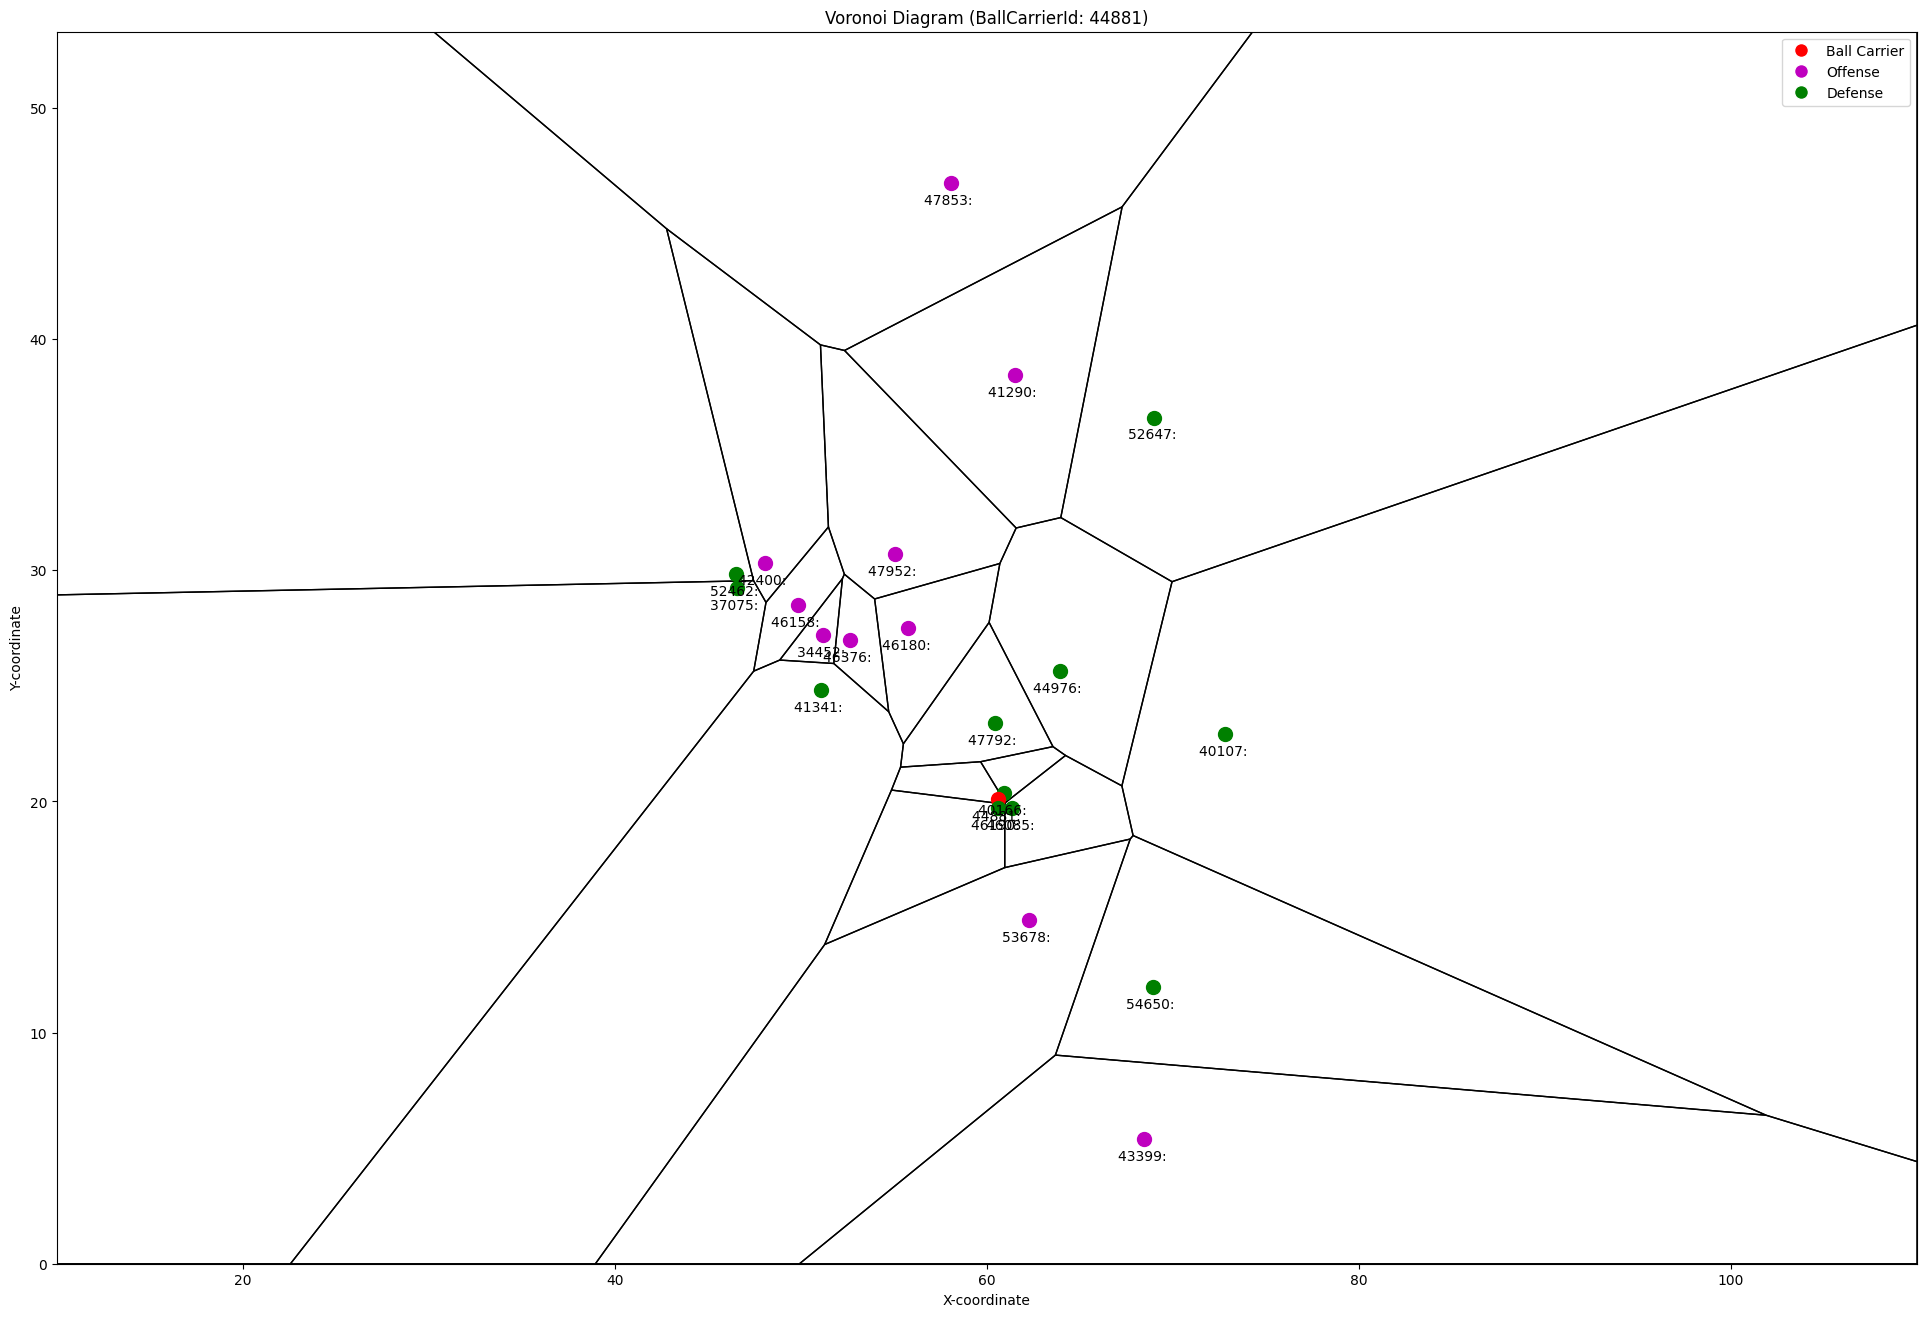

In [46]:
calculate_voronoi_areas(test_frame, plot_graph=True)

,nflId,time,playDirection,x,y,s,a,dis,o,dir,event,is_offense,ballCarrierId,voronoi_area,vertices
12190,34452,2022-09-08 20:37:58.599999,right,51.20,27.18,1.31,0.49,0.13,199.36,165.26,NaN,True,44881,5.374061,"[[51.76778462998102, 25.968078747628084], [48...."
12219,37075,2022-09-08 20:37:58.599999,right,46.54,29.23,0.76,1.25,0.07,84.97,78.58,NaN,False,44881,777.572669,"[[47.461522249923775, 25.636771205136945], [22..."
12248,40107,2022-09-08 20:37:58.599999,right,72.80,22.93,5.02,2.22,0.51,239.80,248.03,NaN,False,44881,991.560923,"[[67.15413212959284, 20.333669118370647], [69...."
12277,40166,2022-09-08 20:37:58.599999,right,60.94,20.37,2.36,2.02,0.22,158.39,310.65,NaN,False,44881,19.314424,"[[61.05655737704918, 19.873344262295085], [64...."
12306,41290,2022-09-08 20:37:58.599999,right,61.51,38.45,0.82,0.10,0.08,246.08,240.41,NaN,True,44881,101.361793,"[[61.57154175973, 31.82987631857528], [52.3461..."
12335,41341,2022-09-08 20:37:58.599999,right,51.08,24.82,1.37,1.23,0.15,349.01,188.52,NaN,False,44881,362.738653,"[[54.72156059469857, 23.88146636888266], [55.5..."
12364,42400,2022-09-08 20:37:58.599999,right,48.06,30.31,0.22,0.94,0.02,170.72,140.63,NaN,True,44881,70.239791,"[[51.480246345912754, 31.875073794920684], [51..."
12393,43399,2022-09-08 20:37:58.599999,right,68.46,5.38,0.37,1.19,0.03,285.80,241.57,NaN,True,44881,401.206998,"[[63.68200364916858, 9.025597330994577], [49.9..."
12422,44881,2022-09-08 20:37:58.599999,right,60.61,20.12,3.30,1.96,0.31,182.87,309.39,NaN,True,44881,7.346627,"[[54.86951499999999, 20.492048499999985], [61...."
12451,44976,2022-09-08 20:37:58.599999,right,63.92,25.64,6.86,3.67,0.69,198.39,196.91,NaN,False,44881,72.987648,"[[60.69775655430712, 30.295128838951317], [61...."


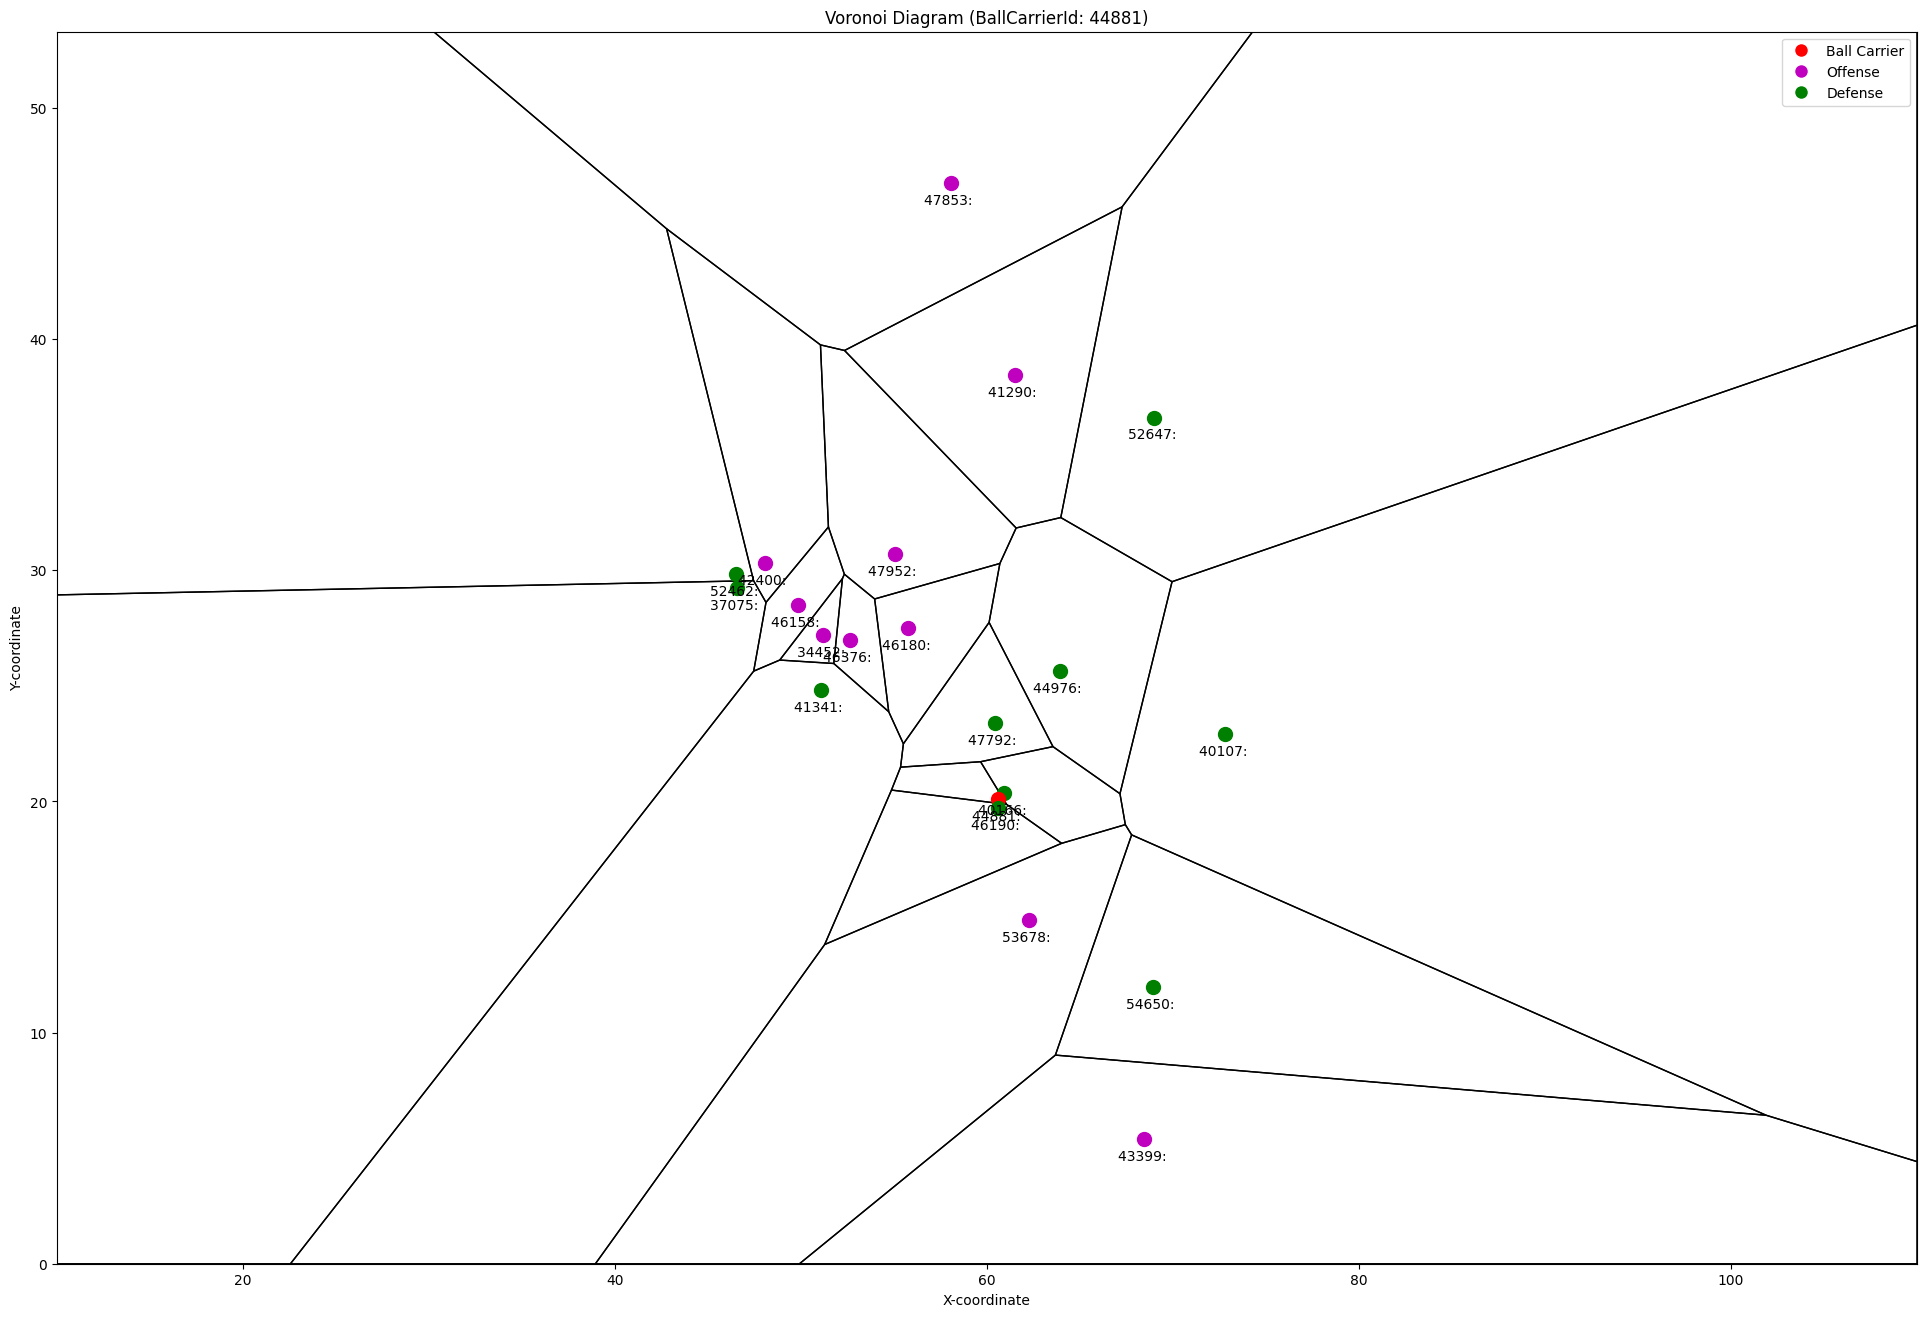

In [47]:
test_frame_truncated = test_frame[test_frame.nflId != 46085]
calculate_voronoi_areas(test_frame_truncated, plot_graph=True)
